Ingreso de datos

In [1]:
import pandas as pd

# Cargar datos
df = pd.read_csv("train.csv")

# Mostrar información general del dataset
print("Dimensiones del dataset:", df.shape)
df.info()

# Resumen estadístico de las variables numéricas
df.describe()

# Valores faltantes por columna (ordenados)
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]


Dimensiones del dataset: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

LIMPIEZA DE DATOS

In [2]:
# Eliminar columnas 
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
df = df.drop(columns=cols_to_drop)

 #valores faltantes

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Categóricos -> valor "Desconocido"
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Desconocido')

df.isnull().sum().sort_values(ascending=False).head(10)


Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
Street         0
LotShape       0
LandContour    0
Utilities      0
LotConfig      0
dtype: int64

SEPARACION DE CARACTERISTICAS Y VARIABLE OBJETIVO

In [3]:
# Separar variables predictoras (X) y objetivo (y)
X = df.drop(columns=['SalePrice', 'Id'])  
y = df['SalePrice']

X.shape, y.shape


((1460, 74), (1460,))

DATOS DE ENTRENAMIENTO

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1168, 74), (292, 74))

CONVERTIR COLUMNAS CATEGORICAS A VALORES NUMERICOS

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# El resto de tu código...
# Identificar columnas categóricas
columnas_categoricas = X.select_dtypes(include=['object']).columns

# Crear un preprocesador para convertir variables categóricas
preprocesamiento = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ],
    remainder='passthrough' # deja las numéricas igual
)

# Crear pipeline: preprocesa y luego entrena
modelo_arbol = Pipeline(steps=[
    ('preprocesamiento', preprocesamiento),
    ('arbol', DecisionTreeRegressor(random_state=42))
])

# Entrenar
modelo_arbol.fit(X_train, y_train)

# Predicción
y_pred = modelo_arbol.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2


(26837.705479452055, np.float64(41986.95057616034), 0.7701657046824053)

CONSTRUCCION DE MODELO

In [ ]:
from sklearn.ensemble import RandomForestRegressor

modelo_rf = Pipeline(steps=[
    ('preprocesamiento', preprocesamiento),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
])

modelo_rf.fit(X_train, y_train)

y_pred_rf = modelo_rf.predict(X_test)


mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, rmse_rf, r2_rf


(17467.666626712326, np.float64(28804.831768153694), 0.8918275037097918)

Interpretación

El Random Forest predice con 89% de precisión y se equivoca en promedio $17,468, lo cual es mucho más realista y sólido.

Esto significa:

- El modelo generaliza mejor
- Los errores grandes se redujeron

VARIABLES IMPORTANTES

In [ ]:
import pandas as pd
import numpy as np

# Extraer modelo Random Forest y el preprocesador del Pipeline
rf = modelo_rf.named_steps['rf']

preprocessor = modelo_rf.named_steps['preprocesamiento']


# Obtener columnas numéricas y categóricas del ColumnTransformer
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
num_features = preprocessor.transformers_[1][2]  # columnas numéricas originales


# Unir nombres de características finales
final_features = np.concatenate([num_features, cat_features])


# Importancias
importancias = rf.feature_importances_

# Crear DataFrame de importancia
importance_df = pd.DataFrame({
    'Característica': final_features,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

importance_df.head(20)


,Característica,Importancia
245,GarageFinish_Fin,0.556489
257,GarageCond_Gd,0.123829
253,GarageQual_TA,0.033713
255,GarageCond_Ex,0.030970
250,GarageQual_Fa,0.027457
254,GarageCond_Desconocido,0.027254
244,GarageFinish_Desconocido,0.017767
268,SaleType_ConLw,0.015299
267,SaleType_ConLI,0.014066
247,GarageFinish_Unf,0.013104


La tabla que aparece es el ranking de las características que más influyen en el precio de la casa, Esto significa que el estado y acabado del garaje está siendo evaluado por el modelo como una de las variables más relevantes para predecir el SalePrice del dataset.

GRAFICA DE VARIABLES

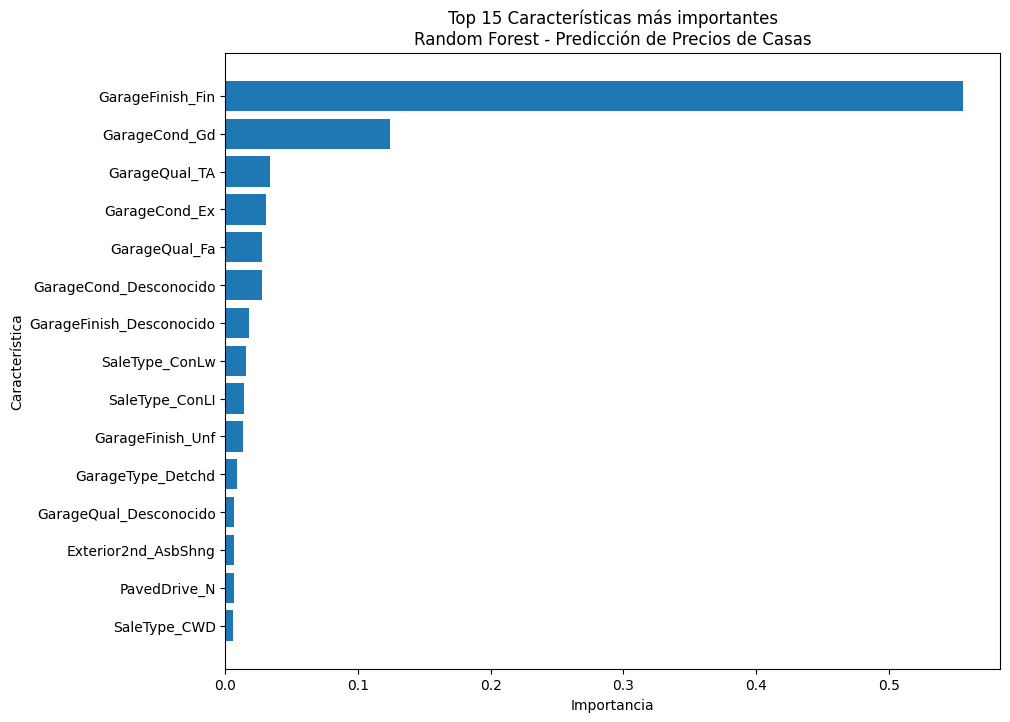

In [ ]:
import matplotlib.pyplot as plt

# Top 15 características
top_n = 15
top_features = importance_df.head(top_n).sort_values('Importancia')

plt.figure(figsize=(10, 8))

plt.barh(top_features['Característica'], top_features['Importancia'])

plt.xlabel('Importancia')

plt.ylabel('Característica')

plt.title('Top 15 Características más importantes\nRandom Forest - Predicción de Precios de Casas')

plt.show()


In [ ]:
top20 = importance_df.head(20)

top20


,Característica,Importancia
245,GarageFinish_Fin,0.556489
257,GarageCond_Gd,0.123829
253,GarageQual_TA,0.033713
255,GarageCond_Ex,0.030970
250,GarageQual_Fa,0.027457
254,GarageCond_Desconocido,0.027254
244,GarageFinish_Desconocido,0.017767
268,SaleType_ConLw,0.015299
267,SaleType_ConLI,0.014066
247,GarageFinish_Unf,0.013104


GRAFICA DE IMPORTANCIA

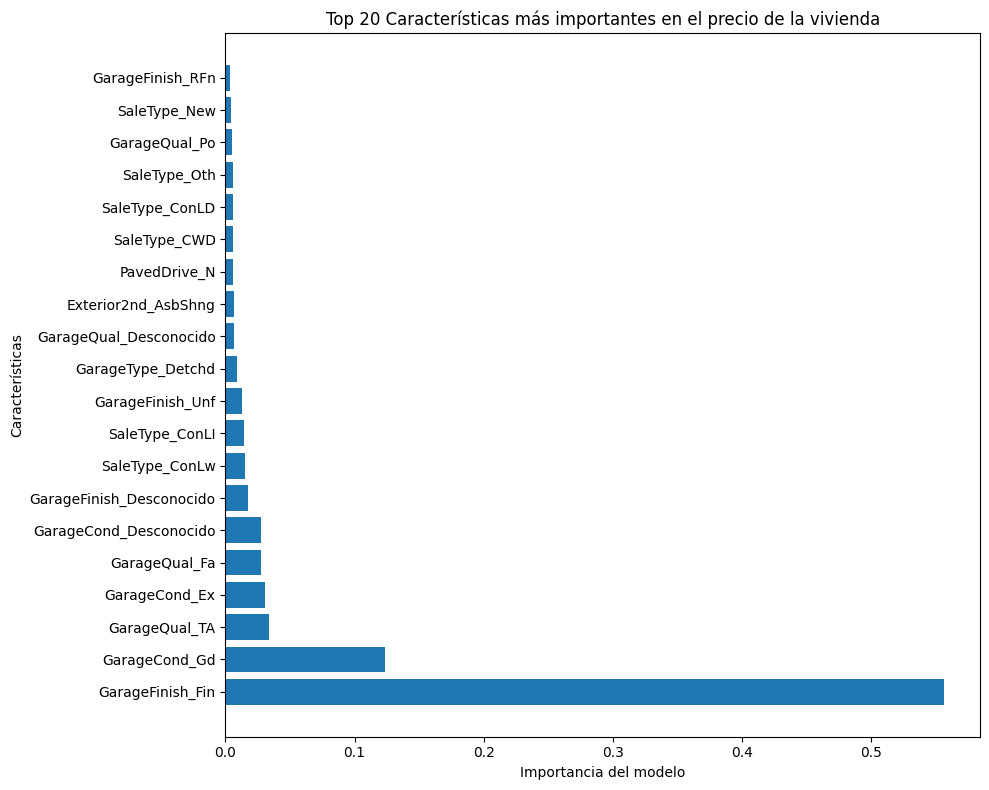

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.barh(top20['Característica'], top20['Importancia'])

plt.title("Top 20 Características más importantes en el precio de la vivienda")

plt.xlabel("Importancia del modelo")

plt.ylabel("Características")

plt.tight_layout()

plt.show()




El modelo muestra que los atributos vinculados al garaje, como la calidad (GarageQual) y el acabado (GarageFinish), tienen un impacto significativo en el valor de la vivienda.  La calidad del sótano, el tipo de venta y los materiales externos son otros rasgos importantes que resaltan la importancia del estado estructural y del mantenimiento de la propiedad para determinar su precio final.

Comparacion de modelos

In [ ]:
# Comparar modelos: DecisionTree, RandomForest, GradientBoosting
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold

models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
}



results = []

# Función para evaluar
def eval_model(name, estimator):
    pipe = Pipeline([
        ('preprocesamiento', preprocesamiento),  # tu ColumnTransformer dentro del pipeline
        ('model', estimator)
    ])
    # Entrenamiento en el split que ya hiciste
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Validación cruzada (5-fold) sobre todo X para una métrica robusta (usamos R2 promedio)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_r2 = cross_val_score(pipe, X, y, cv=kf, scoring='r2', n_jobs=-1).mean()
    
    results.append({
        'Modelo': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2_test': r2,
        'R2_cv5': cv_r2
    })
    print(f"{name} terminado -> R2_test: {r2:.4f}, R2_cv5: {cv_r2:.4f}")


# Ejecutar evaluación para cada modelo
for name, model in models.items():
    eval_model(name, model)


# Resumen en DataFrame ordenado por RMSE ascendente
res_df = pd.DataFrame(results).sort_values('RMSE')
res_df


DecisionTree terminado -> R2_test: 0.7702, R2_cv5: 0.7032


KeyboardInterrupt: 

TUNING DE HIPERPARAMETROS PARA EL MEJOR MODELO "GradientBoosting"

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

# Pipeline base
pipe = Pipeline([
    ('preprocesamiento', preprocesamiento),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__max_depth': randint(2, 6),
    'model__subsample': uniform(0.6, 0.4),
    'model__min_samples_split': randint(2, 20)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=25,  # puedes subirlo a 40-60 si quieres más precisión
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=2
)


random_search.fit(X_train, y_train)


best_model = random_search.best_estimator_

print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor R2 CV:", random_search.best_score_)

# Evaluación final en test
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

mae_best, rmse_best, r2_best


Fitting 5 folds for each of 25 candidates, totalling 125 fits


INTERPRETACION DE CARACTERISTICAS

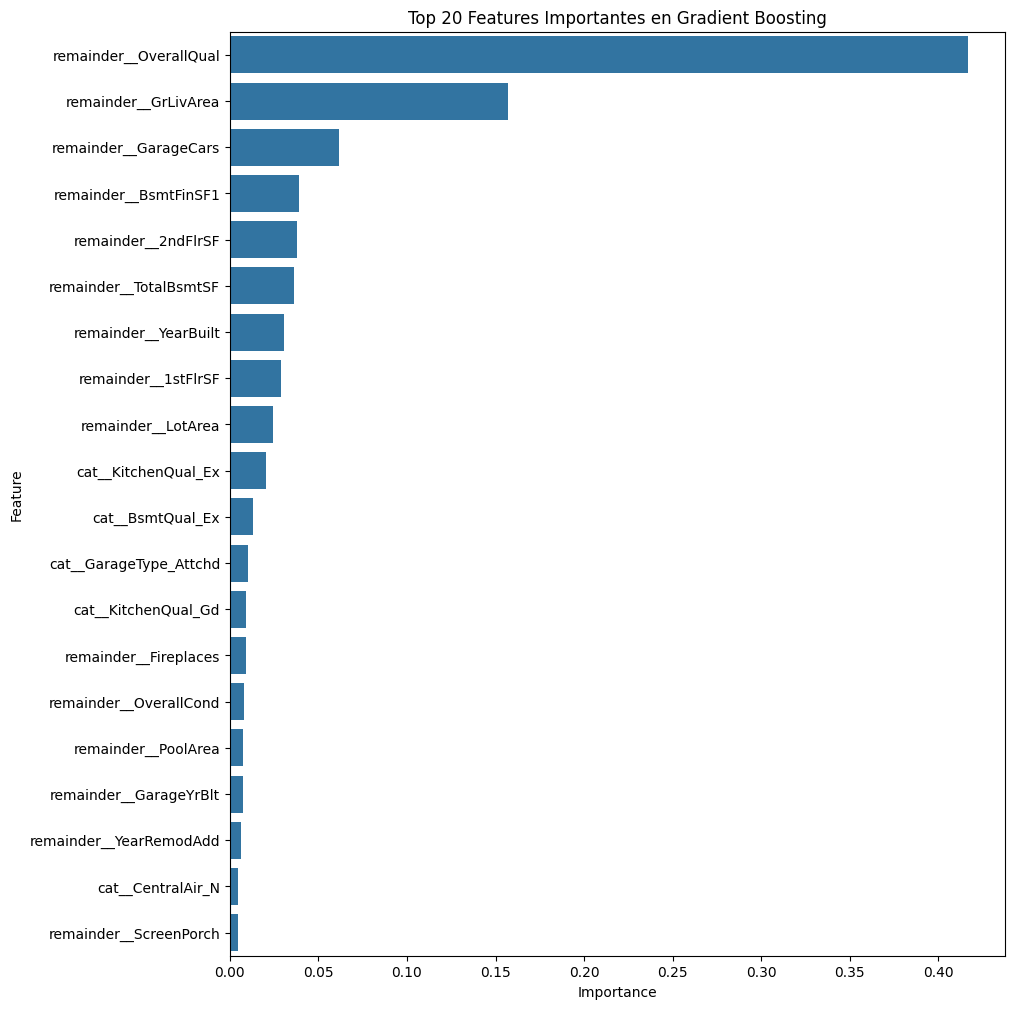

,Feature,Importance
245,remainder__OverallQual,0.416776
257,remainder__GrLivArea,0.156894
267,remainder__GarageCars,0.061455
250,remainder__BsmtFinSF1,0.039216
255,remainder__2ndFlrSF,0.038066
253,remainder__TotalBsmtSF,0.036110
247,remainder__YearBuilt,0.030584
254,remainder__1stFlrSF,0.029101
244,remainder__LotArea,0.024605
190,cat__KitchenQual_Ex,0.020213


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraemos el modelo interno
gb_model = best_model.named_steps['model']
# Importancia de características
feature_importances = gb_model.feature_importances_
feature_names = preprocesamiento.get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Features Importantes en Gradient Boosting')
plt.show()

importance_df.head(20)


CALCULO DE SHAP

In [ ]:
!pip install shap



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
model_only = best_model.named_steps['model']


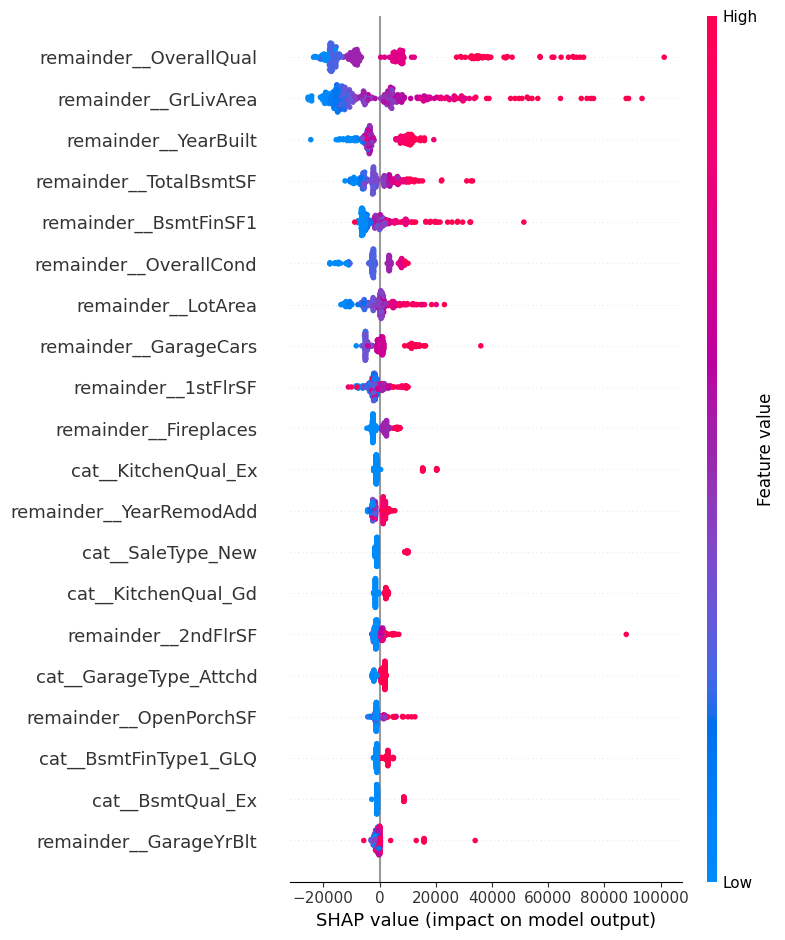

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

preprocess = best_model.named_steps['preprocesamiento']
model_only = best_model.named_steps['model']

# Transformar el conjunto de prueba (devuelve csr_matrix)
X_test_processed = preprocess.transform(X_test)

# Convertir a denso y asegurar tipo float
X_test_processed = X_test_processed.toarray().astype(float)

# Nuevos nombres de columnas tras OneHotEncoding
feature_names_shap = preprocess.get_feature_names_out()

# Crear explainer
explainer = shap.TreeExplainer(model_only)

# Obtener valores SHAP
shap_values = explainer.shap_values(X_test_processed)

# Gráfico resumen
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names_shap, plot_type="dot")


IMPACTO INDIVIDUAL DE VARIABLES

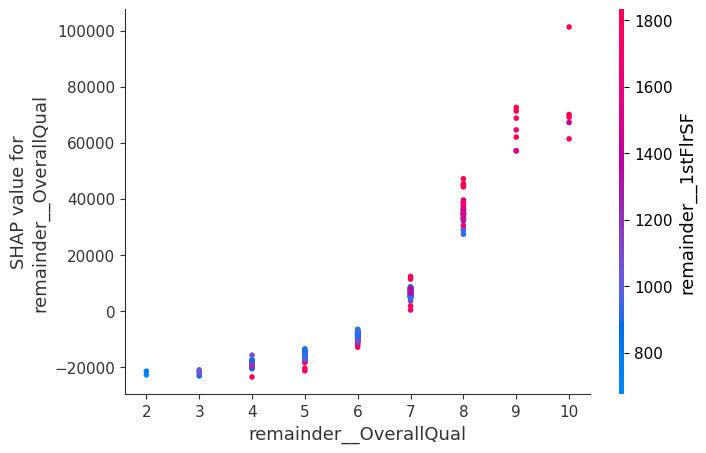

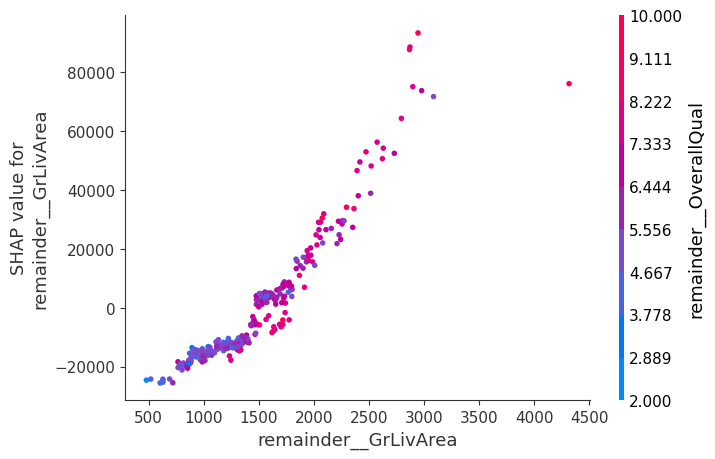

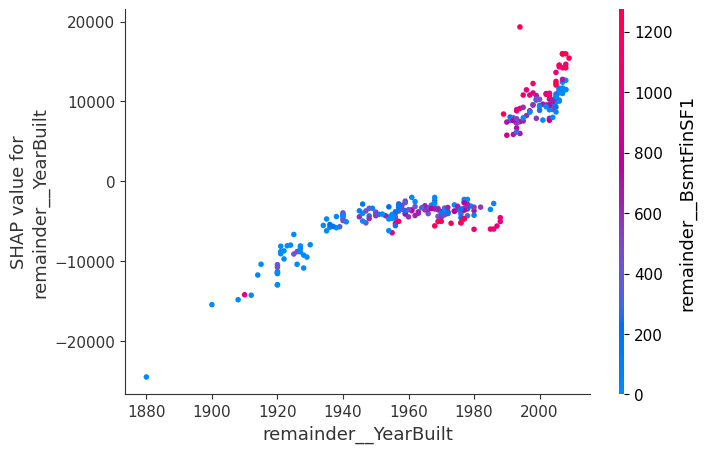

In [ ]:
features_to_plot = ['remainder__OverallQual', 'remainder__GrLivArea', 'remainder__YearBuilt']

for feat in features_to_plot:
    shap.dependence_plot(feat, shap_values, X_test_processed, feature_names=feature_names)


El modelo aprende que el precio de una casa se explica principalmente por su calidad, su tamaño y su antigüedad. Además, SHAP nos revela interacciones: no es solo tener una casa grande, sino tambien bien construida, no es solo que sea nueva, sino con espacios acabados. 

Error del modelo en función del precio real: Esto ayuda a mostrar si el modelo falla más en casas baratas o caras.

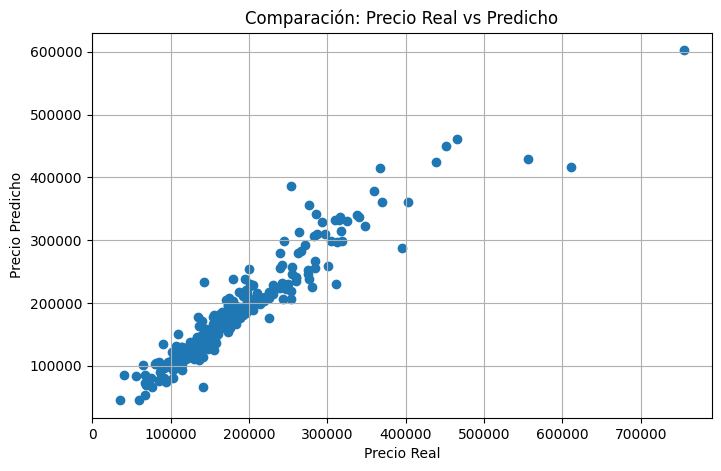

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_best)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Comparación: Precio Real vs Predicho")
plt.grid(True)
plt.show()


Distribución de errores (residuos): Sirve para validar si el modelo se comporta de forma estable.

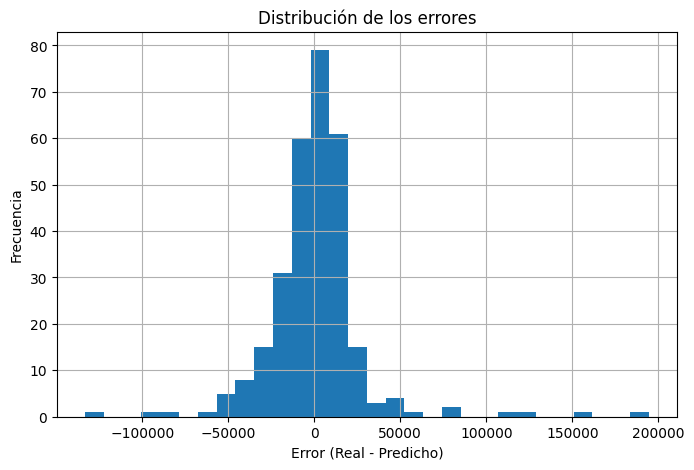

In [ ]:
errors = y_test - y_pred_best

plt.figure(figsize=(8,5))
plt.hist(errors, bins=30)
plt.xlabel("Error (Real - Predicho)")
plt.ylabel("Frecuencia")
plt.title("Distribución de los errores")
plt.grid(True)
plt.show()
